# A Gentle Introduction to Generative Adversarial Networks (GAN) with Keras and the Tensorflow Backend

Generative Adversarial Networks (GAN) is one of the most promising recent developments in Deep Learning.


## What is GAN?

[GAN](http://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), introduced by Ian Goodfellow in 2014, attacks the problem of unsupervised learning by training __two deep networks__, called Generator and Discriminator, that compete and cooperate with each other. In the course of training, both networks eventually learn how to perform their tasks.

The most famous application of GAN would be Google's [AlphaGo](https://arxiv.org/pdf/1711.09091.pdf). So the new world champion of the game of Go is trained by playing constantly with itself. Watch the video below for more details.


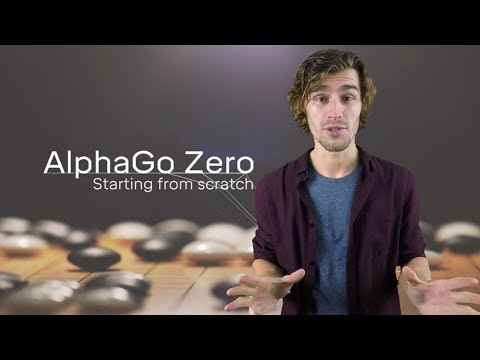

In [ ]:
from IPython.display import YouTubeVideo
# https://youtu.be/MgowR4pq3e8
YouTubeVideo('MgowR4pq3e8')

GAN is almost always explained like the case of a counterfeiter (Generative) and the police (Discriminator).
- Initially, the counterfeiter will show the police a __fake note__($). The police says it is __fake__ with the reasons why the money is fake.
- Then the counterfeiter attempts to make a new fake money based on the feedback it received. The police says the money is still fake and offers a new set of feedback.
- Again the counterfeiter attempts to make a new fake money based on the latest feedback. The cycle continues indefinitely until the police is fooled by the fake money because it looks real.

While the idea of GAN is simple in theory, it is very difficult to build a model that works. In GAN, there are two deep networks coupled together making back propagation of gradients twice as challenging. __Deep Convolutional GAN__ (DCGAN) is one of the models that demonstrated how to build a practical GAN that is able to learn by itself how to synthesize new images. The idea is that we train a GAN model that can mimic the handwritten digits in the MNIST dataset.



In [ ]:
# import required packages
# specify the version of tensorflow
%tensorflow_version 1.x
import tensorflow as tf

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

TensorFlow 1.x selected.


In [ ]:
# import other components
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, RMSprop
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU, Dropout

## Components of the GAN

As said above, any GAN would contain a __discriminator__ and a __generator__.

### Discriminator
In the context of this tutorial, the __discriminator__'s purpose is to tell whether an generated image is real, and how real it is. Essentially, it is basically a deep Convolutional Neural Network (CNN) as shown in the figure below.

![discriminator illustration](https://drive.google.com/uc?id=1ofm6kTNQd4qEoIhroSD-GU7ZIcyfCsaw)


For MNIST Dataset used in this tutorial, the input is an image (28 pixel x 28 pixel x 1 channel). The __sigmoid__ output is a scalar value of the probability of how real the image is (`0.0` is certainly __fake__, `1.0` is certainly __real__, anything in between is a gray area).

The difference from a typical CNN includes:
- the absence of __max-pooling__ layers in between layers. Instead, a __strided convolution__ is used for downsampling.
- The activation function used in each CNN layer is a __leaky ReLU__.
- A dropout between `0.4` and `0.7` between layers prevent over fitting and memorization.

Now we can define the discriminator class. This is a little bit different from the tutorials you have seen before, where we build the models as in the pipeline. In production code, we would define the models as classes, and call them in the actual pipeline.

In [ ]:
discriminator = Sequential([
        Convolution2D(64, 5,  strides=2, input_shape=(28,28,1), padding='same', activation=LeakyReLU(0.2)),
        Dropout(0.4),
        Convolution2D(128, 5,  strides=2, padding='same', activation=LeakyReLU(0.2)),
        Dropout(0.4),
        Flatten(),
        Dense(1, activation='sigmoid')
   ])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

### Generator

The generator synthesizes fake images. As shown in the figure below, the fake image is generated from a 100-dimensional noise (uniform distribution between -1.0 to 1.0) using the inverse of convolution, called [transposed convolution](https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8).

Instead of fractionally-strided convolution as suggested in DCGAN, upsampling between the first three layers is used since it synthesizes more realistic handwriting images.

In between layers, batch normalization stabilizes learning. The activation function after each layer is a ReLU. The output of the sigmoid at the last layer produces the fake image. Dropout of between 0.3 and 0.5 at the first layer prevents overfitting.

![generator illustration](https://drive.google.com/uc?id=1iAO_EvXAUFYxhIXpfaALYvlTlLevAbOW)


In [ ]:
generator = Sequential([
        # dense - input layer
        # In: 100
        # Out: dim x dim x depth
        #Dense(depth*dim*dim, input_dim=100, activation='relu'),
        #BatchNormalization(momentum=0.9),
        #Reshape((dim,dim,depth)),
        #Dropout(dropout),
        Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Reshape((7,7,128)),
        Dropout(0.4),

        UpSampling2D(),
        Convolution2D(64, 5, strides=(1,1), padding='same', activation=LeakyReLU(0.2)),
        BatchNormalization(momentum=0.9),

        UpSampling2D(),
        Convolution2D(1, 5, strides=(1,1), padding='same', activation='tanh')
    ])

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)       

## GAN Model
So far, we have outlined the architectures of the discriminator and the generator. As you can recall from the previous tutorials in this course, we need to initialize the architecture(s), with parameters, as the models, for the training purposes. We need two models:
1.  Discriminator Model (the police) and
2. Adversarial Model or Generator-Discriminator (the counterfeiter learning from the police).

### Discriminator Model
The code block below shows the Keras code for the Discriminator Model.

It takes the Discriminator architecture with a few arguments for the training purposes.
- The first argument is the __loss function__ defined for training. Since the output of the Discriminator is sigmoid, we use binary cross entropy for the loss, since `fake/real` is a binary classification problem.
- The second argument is the __optimizer__. We use RMSProp as optimizer generates more realistic fake images compared to Adam for this case. We set the learning rate decay to 0.0008. Weight decay and clip value stabilize learning during the latter part of the training. You have to adjust the decay if you adjust the learning rate.
- Accordingly, we use the __accuracy__ as the evaluation metric given the selected loss function and optimizer.

In [ ]:
g_optimizer = RMSprop(lr=0.0001, decay=3e-8)
#generator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
generator.compile(loss='binary_crossentropy', optimizer=g_optimizer, metrics=['accuracy'])
d_optimizer = RMSprop(lr=0.0002, decay=6e-8)
discriminator.compile(loss='binary_crossentropy', optimizer=d_optimizer, metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Adversarial Model (`gan`)
The adversarial  model is just the generator-discriminator stacked together as shown in the figure below. The __Generator__ part is trying to fool the __Discriminator__ and learning from its feedback at the same time. The training parameters are the same as in the Discriminator model except for a reduced learning rate and corresponding weight decay.

![adversarial model](https://miro.medium.com/max/1400/1*PIpd1jHbPc2QrTOPhvxoaw.png)

In [ ]:
discriminator.trainable = False
ganInput = Input(shape=(100,))
# getting the output of the generator
# and then feeding it to the discriminator
# new model = D(G(input))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(ganInput, ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=Adam())
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


## Training the GAN Model
Training is the hardest part. Comparing to the training of traditional neural networks, we need to train the discriminator first separately, with the real and fake images. The purpose of this step is to make sure that the discriminator can make independent and unbiased decision to decide if a _generated_ image is real or fake. This decision needs to standalone from the generator.

Then, the Discriminator and Adversarial models are trained one after the other - so that in the Adversarial models the discriminator and the generator can communicate with each other. So that the discriminator can provide feedback to why the image is fake and the generator can be further trained with the feedback.

Below figure shows the training process in one epoch, and the communication between the discriminator and the generator is facilitated between the epochs.

![Train the AM model](https://miro.medium.com/max/1400/1*N3nT9AXVnsFBta2R1eEMjg.png)


In [ ]:
def train(epoch=10, batch_size=128):
    batch_count = X_train.shape[0] // batch_size

    for i in range(epoch):
        for j in tqdm(range(batch_count)):
            # Input for the generator
            noise_input = np.random.rand(batch_size, 100)

            # getting random images from X_train of size=batch_size
            # these are the real images that will be fed to the discriminator
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

            # these are the predicted images from the generator
            predictions = generator.predict(noise_input, batch_size=batch_size)

            # the discriminator takes in the real images and the generated images
            X = np.concatenate([predictions, image_batch])

            # labels for the discriminator
            y_discriminator = [0]*batch_size + [1]*batch_size

            # Let's train the discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_discriminator)

            # Let's train the generator
            noise_input = np.random.rand(batch_size, 100)
            y_generator = [1]*batch_size
            discriminator.trainable = False
            gan.train_on_batch(noise_input, y_generator)

Training GAN models requires a lot of patience due to its depth. Here are some pointers:
- __Problem__: generated images as noise at the beginning.
  - Solution: use __dropout__ on both Discriminator and Generator. Low dropout values (`0.3` to `0.6`) generate more realistic images.
- Problem: Discriminator loss converges rapidly to zero thus preventing the Generator from learning.
  - Solution: __Do not pre-train the Discriminator__. Instead make its learning rate __greater__ than the Adversarial model learning rate. Use a different training noise sample for the Generator.
- Problem: generator images still look like noise.
  - Solution: check if the _activation, batch normalization and dropout_ are applied in the correct sequence.
- Problem: figuring out the correct training/model parameters.
  - Solution: start with some known working values from published papers and codes and adjust __one parameter at a time__. Before training for `2000` or more steps (for better quality of the generated iamges), observe the effect of parameter value adjustment at about `500` or `1000` steps (for fast training).

Now we can start loading our data. Colab provides the MNIST dataset but it is a chopped version. We will use the full version come with `tensorflow`.

In [ ]:
mnist = tf.keras.datasets.mnist
#mnist_data = mnist.load_data()
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')

# Scaling the range of the image to [-1, 1]
# Because we are using tanh as the activation function in the last layer of the generator
# and tanh restricts the weights in the range [-1, 1]
X_train = (X_train - 127.5) / 127.5
#X_train = X_train.reshape((-1,1))
X_train.shape

(60000, 28, 28, 1)

Now we can train the model.

In [ ]:
train(100, 128)

100%|██████████| 468/468 [00:12<00:00, 38.48it/s]


Let's save the trained model state just in case.

In [ ]:
generator.save_weights('gen_100_scaled_images.h5')
discriminator.save_weights('dis_100_scaled_images.h5')

We can train the model again for another `100` epochs.

In [ ]:
train(100, 128)

Saving the model again...

In [ ]:
generator.save_weights('gen_200_scaled_images.h5')
discriminator.save_weights('dis_200_scaled_images.h5')

Now load the saved model back.

In [ ]:
generator.load_weights('gen_200_scaled_images.h5')
discriminator.load_weights('dis_200_scaled_images.h5')

Also, let's define a function to plot the original and generated images.

In [ ]:
def plot_output(fake=True):

    if fake: # fake = True

      try_input = np.random.rand(100, 100)
      preds = generator.predict(try_input)

    else: # fake = False
        i = np.random.randint(0, X_train.shape[0], 100)
        preds = X_train[i, :, :, :]

    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()


Let's first look at the original images.



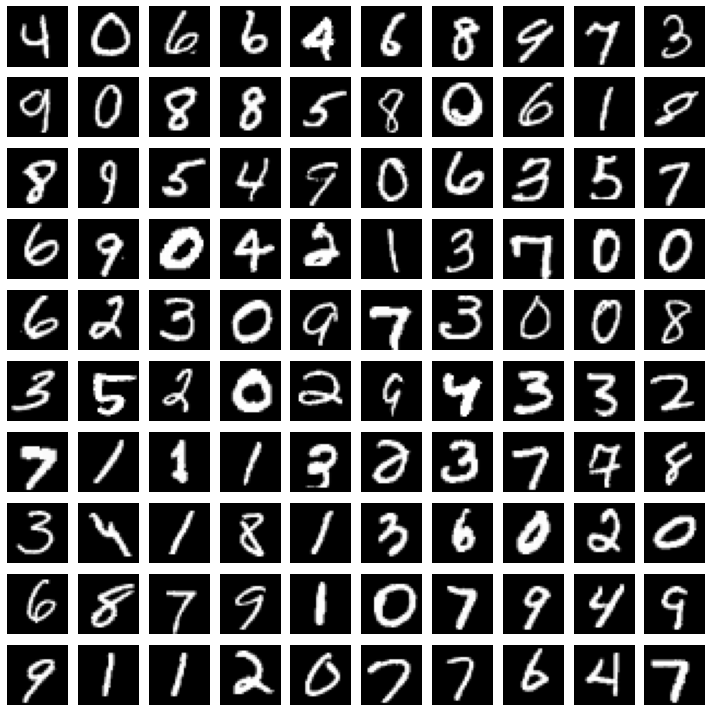

In [ ]:
plot_output(fake=False)

Now we can look at the generated images by our GAN.

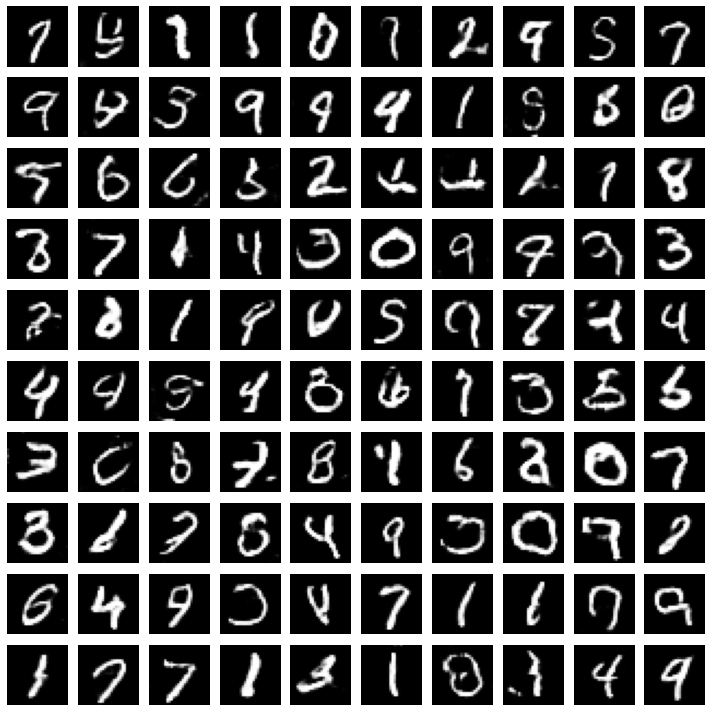

In [ ]:
plot_output()

Observing above images is fascinating. The GAN is learning how to write handwritten digits on its own!

## Conclusion

Now you know how Generative Adversarial Networks work. A few things to recap:
- you need to train both the discriminator and the generator. The discriminator needs to be trained on its own, then trained together with the generator;
- the discriminator examines the data generated by the generator, and provides feedback for the generator to improve;
- The training stops when the discriminator agrees that the generated images are "genuine".

## Homework

Here are a few questions to strengthen your understanding on GAN.

### Q1. Try different sample sizes or training epochs and observe the results.

Train subsets of `X_train` at different sizes (e.g. 10,000, 20,000, 30,000, 40,000, 50,000) or tweak the `epoch` parameter in the `train()` function (e.g., 50, 100, 150) to see how these two hyperparameters affect your results (generated images).

### Q2. Describe different use cases of GAN.

List at least two use cases of GAN in different fields (preferrably in the business domain, e.g. finance, marketing) that it will be very useful.